<a href="https://colab.research.google.com/github/AndyYeom/Student-ID-Scanning/blob/main/CMM_CV_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras
!pip install tensorflow



In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd
import os
import random

from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

In [ ]:
testpath = '/content/drive/MyDrive/HKU CMM CV - HKU ID SCANNING/test'
trainingpath = '/content/drive/MyDrive/HKU CMM CV - HKU ID SCANNING/train'
validpath = '/content/drive/MyDrive/HKU CMM CV - HKU ID SCANNING/valid'

#defining preprocessing transformation (training data)

train_datagen = ImageDataGenerator(rescale = 1./255)

#defining preprocessing transformation (testing data)
test_datagen = ImageDataGenerator(rescale = 1./255)

#generate training data

training_set = train_datagen.flow_from_directory(
        trainingpath,
        target_size = (128,128),
        batch_size =32,
        class_mode = 'categorical')

#generate testing data

testing_set = test_datagen.flow_from_directory(
        testpath,
        target_size = (128,128),
        batch_size =32,
        class_mode = 'categorical')

valid_set = test_datagen.flow_from_directory(
        validpath,
        target_size = (128,128),
        batch_size =32,
        class_mode = 'categorical')

import PIL
from PIL import UnidentifiedImageError
from PIL import Image
import glob

imgs_ = glob.glob("/content/drive/MyDrive/HKU CMM CV - HKU ID SCANNING/valid/*/*.jpeg")

for img in imgs_:
    try:
        img = PIL.Image.open(img)
    except PIL.UnidentifiedImageError:
        print(img)

Found 202 images belonging to 2 classes.
Found 35 images belonging to 2 classes.
Found 86 images belonging to 2 classes.


In [ ]:
cv2.imread('/content/drive/MyDrive/HKU CMM CV - HKU ID SCANNING/train/HKU cards/004.jpeg').shape

(1124, 843, 3)

## Reading the images data

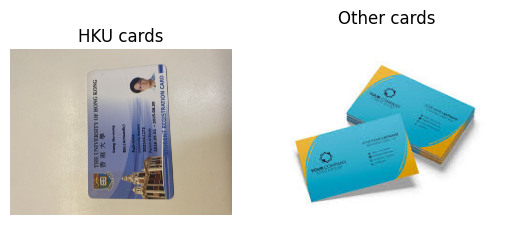

In [ ]:
#plot random image from dataset
def showImages(class_name):
  random_index = random.choice(list(range(1, 49)))
  folder_path = os.path.join(trainingpath, class_name)
  try:
    image_path = os.path.join(folder_path, str(random_index).zfill(3)+".jpeg")
    plt.imshow(mpimg.imread(image_path))
  except:
    image_path = os.path.join(folder_path, str(random_index).zfill(2)+".jpeg")
    plt.imshow(mpimg.imread(image_path))
  plt.title(class_name)
  plt.axis(False)

plt.figure(figsize = (20,20))
for labels, number in training_set.class_indices.items():
  plt.subplot(6,6,number+1)
  showImages(labels)

In [ ]:
testing_set.class_indices

{'HKU cards': 0, 'Other cards': 1}

In [ ]:
#numeric tag for each cards
Trainclasses = training_set.class_indices


ResultMap = {}
for cardValue, cardName in zip(Trainclasses.values(), Trainclasses.keys()):
  ResultMap[cardValue] = cardName

#saving the map for furture reference
import pickle
with open("/content/drive/MyDrive/HKU CMM CV - HKU ID SCANNING/resultmap.pkl","wb") as f:
  pickle.dump(ResultMap, f, pickle.HIGHEST_PROTOCOL)
print(ResultMap)


OutputNeurons = len(ResultMap)
print('\n The Number of OuputNeurons:', OutputNeurons)

{0: 'HKU cards', 1: 'Other cards'}

 The Number of OuputNeurons: 2


##CNN Model(No data augmentation)

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# Initialize
#use (64,64,3) format (Tensorflow backend)

simple_model = Sequential()

#1 Convolution

simple_model.add(Convolution2D(32, kernel_size = (3,3), strides = (1,1), input_shape = (128, 128, 3), activation = 'relu'))

#2 Max Pooliing

simple_model.add(MaxPool2D(pool_size = (2,2)))

#addition layer for better accuracy

simple_model.add(Convolution2D(64, kernel_size = (3,3), strides = (1,1), activation = 'relu'))

simple_model.add(MaxPool2D(pool_size = (2,2)))

#3 Flattening
simple_model.add(Flatten())

#4 Connecting neural network
simple_model.add(Dense(256, activation = 'relu'))
simple_model.add(Dense(OutputNeurons, activation = 'softmax'))

simple_model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ["accuracy"])

simple_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 256)               1

##Training (No data augmentation)

In [ ]:
#complie and fit
from tensorflow.keras import optimizers

#complie
simple_model.compile(
    optimizer = optimizers.RMSprop(),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

#fit
import time
StartTime = time.time()

simple_model_fit = simple_model.fit(
    training_set,
    steps_per_epoch = 6,
    epochs = 20,
    validation_data = valid_set,
    validation_steps = 3)

EndTime = time.time()
print("Total time taken: ", round((EndTime - StartTime)/60), "Minutes")


accuracy = simple_model_fit.history['accuracy']
val_accuracy = simple_model_fit.history['val_accuracy']

loss = simple_model_fit.history['loss']
val_loss = simple_model_fit.history['val_loss']



Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 4.3607 - accuracy: 0.5412

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6/6 [==============================] - 57s 9s/step - loss: 4.3607 - accuracy: 0.5412 - val_loss: 0.6240 - val_accuracy: 0.6977
Epoch 2/20
6/6 [==============================] - 20s 3s/step - loss: 0.5233 - accuracy: 0.8176 - val_loss: 0.4055 - val_accuracy: 0.8953
Epoch 3/20
6/6 [==============================] - 20s 4s/step - loss: 0.5734 - accuracy: 0.7588 - val_loss: 0.5225 - val_accuracy: 0.7209
Epoch 4/20
6/6 [==============================] - 19s 3s/step - loss: 0.2793 - accuracy: 0.9000 - val_loss: 0.9223 - val_accuracy: 0.7093
Epoch 5/20
6/6 [==============================] - 22s 4s/step - loss: 0.4023 - accuracy: 0.8281 - val_loss: 0.3572 - val_accuracy: 0.9070
Epoch 6/20
6/6 [==============================] - 19s 3s/step - loss: 0.2570 - accuracy: 0.8882 - val_loss: 0.7806 - val_accuracy: 0.7209
Epoch 7/20
6/6 [==============================] - 19s 3s/step - loss: 0.1874 - accuracy: 0.9353 - val_loss: 0.4741 - val_accuracy: 0.8605
Epoch 8/20
6/6 [=============================

##Training result(No data augmentation)

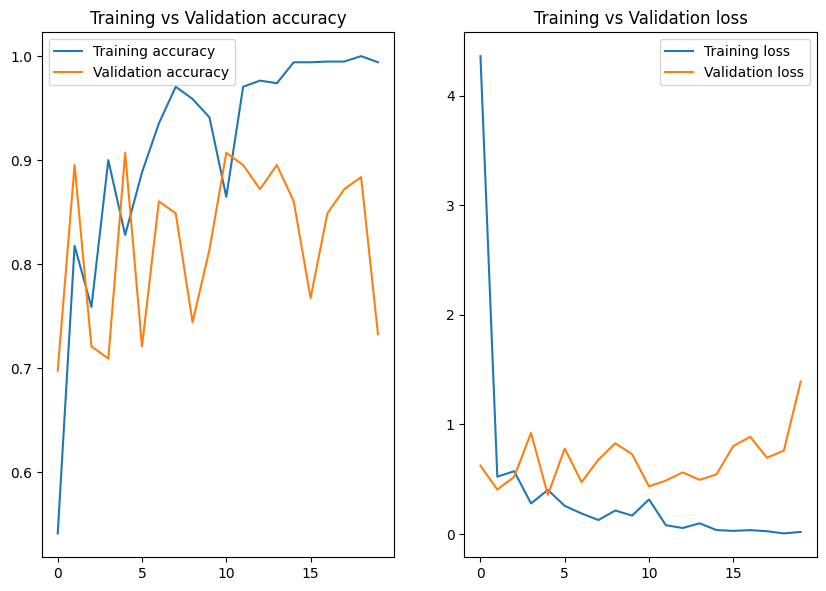

In [ ]:
plt.figure(figsize = (10,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label = "Validation accuracy")
plt.legend()
plt.title("Training vs Validation accuracy")

plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label = "Validation loss")
plt.legend()
plt.title("Training vs Validation loss")


plt.show()

##Data augmentation

In [ ]:
#to prevent overfitting

train_aug_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.3,
    horizontal_flip = True,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
    rescale = 1./255)


train_aug_datagenerator = train_aug_datagen.flow_from_directory(
    directory = trainingpath,
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'categorical'
)

validation_datagenerator = validation_datagen.flow_from_directory(
    directory = validpath,
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 202 images belonging to 2 classes.
Found 86 images belonging to 2 classes.


##Visualize data augmentation

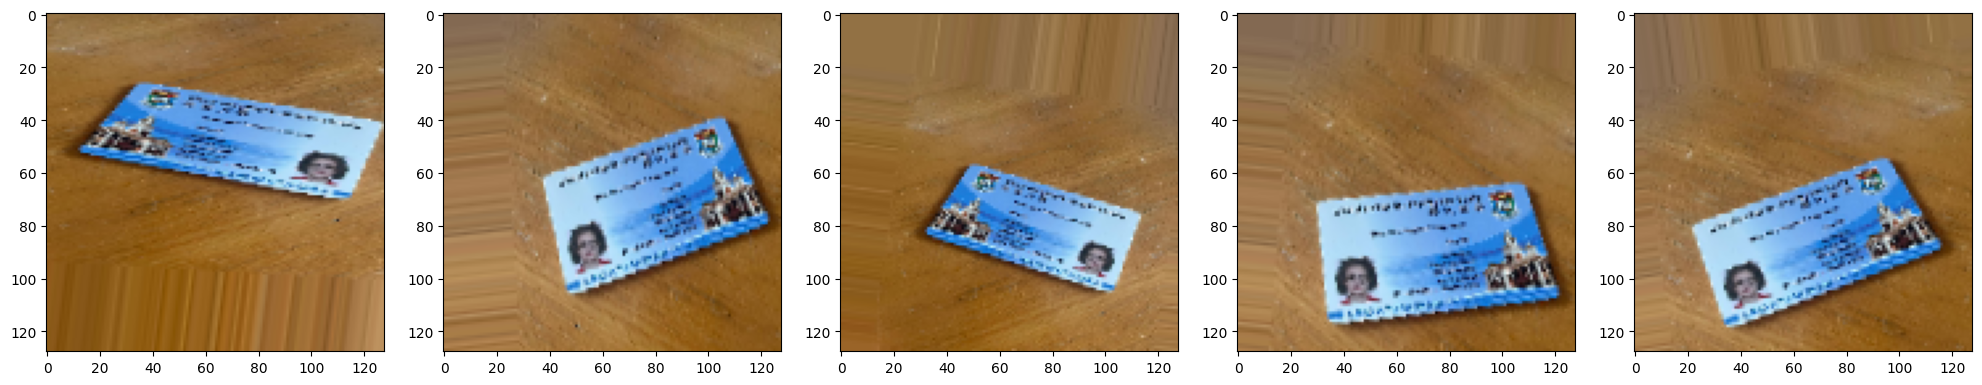

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_aug_datagenerator[0][0][0] for i in range(5)]
plotImages(augmented_images)

##CNN model(data augmentation)

In [ ]:
dataAug_model = Sequential()

#1 Convolution

dataAug_model.add(Convolution2D(32, kernel_size = (3,3), strides = (1,1), input_shape = (128, 128, 3), activation = 'relu'))

#2 Max Pooliing

dataAug_model.add(MaxPool2D(pool_size = (2,2)))

#addition layer for better accuracy

dataAug_model.add(Convolution2D(64, kernel_size = (3,3), strides = (1,1), activation = 'relu'))

dataAug_model.add(MaxPool2D(pool_size = (2,2)))

#3 Flattening
dataAug_model.add(Flatten())

#4 Connecting neural network
dataAug_model.add(Dense(256, activation = 'relu'))
dataAug_model.add(Dense(OutputNeurons, activation = 'softmax'))

dataAug_model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ["accuracy"])

dataAug_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 57600)             0         
                                                                 
 dense_2 (Dense)             (None, 256)              

##Training(data augmentation)

In [ ]:
#complie
dataAug_model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
#Fit
StartTime2 = time.time()

dataAug_model_fit = dataAug_model.fit(
    train_aug_datagenerator,
    steps_per_epoch = 6,
    epochs = 20,
    validation_data = validation_datagenerator,
    validation_steps = 3)

EndTime2 = time.time()
print("Total time taken: ", round((EndTime2 - StartTime2)/60), "Minutes")

accuracy2 = dataAug_model_fit.history['accuracy']
val_accuracy2 = dataAug_model_fit.history['val_accuracy']

loss2 = dataAug_model_fit.history['loss']
val_loss2 = dataAug_model_fit.history['val_loss']


Epoch 1/20
6/6 [==============================] - 22s 3s/step - loss: 1.0825 - accuracy: 0.5882 - val_loss: 0.5939 - val_accuracy: 0.7093
Epoch 2/20
6/6 [==============================] - 22s 4s/step - loss: 0.5274 - accuracy: 0.7235 - val_loss: 0.4124 - val_accuracy: 0.8023
Epoch 3/20
6/6 [==============================] - 20s 3s/step - loss: 0.4673 - accuracy: 0.8412 - val_loss: 0.3770 - val_accuracy: 0.8488
Epoch 4/20
6/6 [==============================] - 23s 3s/step - loss: 0.3573 - accuracy: 0.8765 - val_loss: 0.3383 - val_accuracy: 0.8837
Epoch 5/20
6/6 [==============================] - 21s 3s/step - loss: 0.2440 - accuracy: 0.9235 - val_loss: 0.3840 - val_accuracy: 0.9070
Epoch 6/20
6/6 [==============================] - 21s 3s/step - loss: 0.2751 - accuracy: 0.8824 - val_loss: 0.3580 - val_accuracy: 0.8488
Epoch 7/20
6/6 [==============================] - 19s 3s/step - loss: 0.2465 - accuracy: 0.9176 - val_loss: 0.3246 - val_accuracy: 0.9186
Epoch 8/20
6/6 [==================

##Training result(Data augmentation)

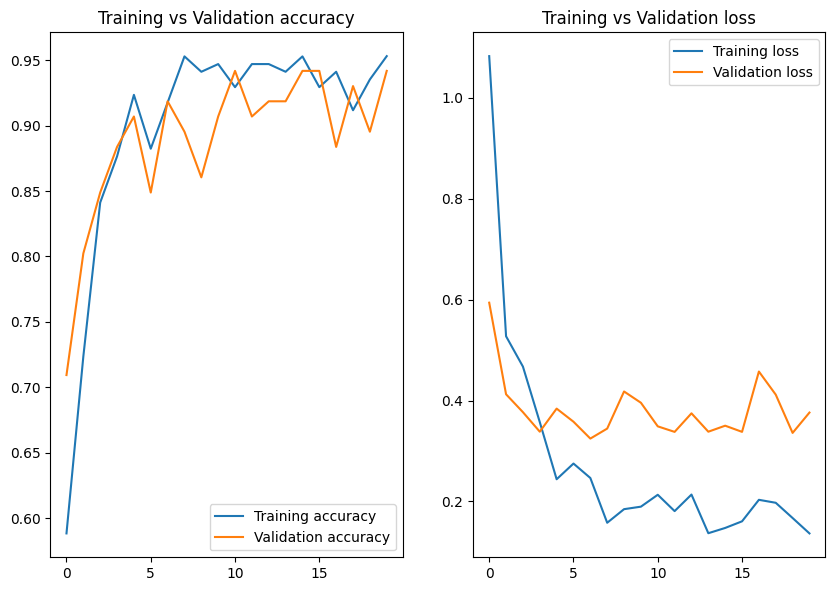

In [ ]:
plt.figure(figsize = (10,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy2, label = "Training accuracy")
plt.plot(val_accuracy2, label = "Validation accuracy")
plt.legend()
plt.title("Training vs Validation accuracy")

plt.subplot(2, 2, 2)
plt.plot(loss2, label = "Training loss")
plt.plot(val_loss2, label = "Validation loss")
plt.legend()
plt.title("Training vs Validation loss")


plt.show()


##Comparison

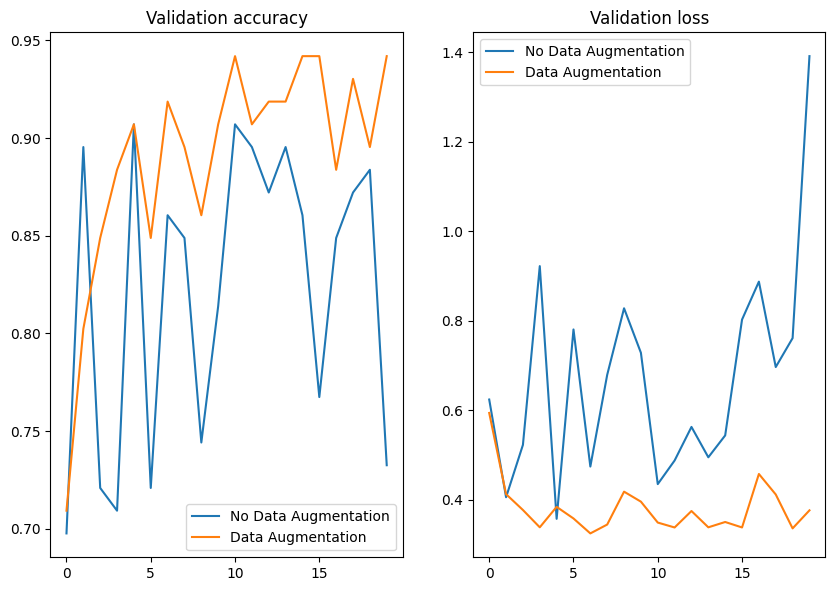

In [ ]:
plt.figure(figsize = (10,15))

plt.subplot(2, 2, 1)
plt.plot(simple_model_fit.history['val_accuracy'], label = "No Data Augmentation")
plt.plot(dataAug_model_fit.history['val_accuracy'], label = "Data Augmentation")
plt.legend()
plt.title("Validation accuracy")

plt.subplot(2, 2, 2)
plt.plot(simple_model_fit.history['val_loss'], label = "No Data Augmentation")
plt.plot(dataAug_model_fit.history['val_loss'], label = "Data Augmentation")
plt.legend()
plt.title("Validation loss")


plt.show()

##Saving the model

In [ ]:
dataAug_model.save("/content/drive/MyDrive/HKU CMM CV - HKU ID SCANNING/model.pkl")

##Testing

In [ ]:
testing_set_img = []
testing_set_label = []

for folder in os.listdir(testpath):
    folder_path = os.path.join(testpath, folder)
    if folder == "HKU cards":
        label = 1
    else:
        label = 0
    for file in os.listdir(folder_path):
        if file.endswith(".jpeg"):
            image = cv2.imread(os.path.join(folder_path, file))
            if image.shape != (128, 128, 3):
                image = cv2.resize(image, (128, 128))
            testing_set_img.append(image)
            testing_set_label.append(label)

testing_img = np.array(testing_set_img)
testing_label = np.array(testing_set_label)

result = dataAug_model.predict(testing_img)
labels = np.where(result >= 0.5, 1, 0)
predicted_labels = labels.tolist()
predicted_labels = np.argmax(predicted_labels, axis=1)

accuracy = np.mean(predicted_labels == testing_label)
print("Accuracy:", accuracy)




2/2 [==============================] - 0s 37ms/step
Accuracy: 0.5142857142857142


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def img_classification(image):
  image = load_img(image, target_size=(128, 128, 3))
  img = img_to_array(image)
  img = np.expand_dims(img,axis = 0)
  img = np.vstack([img])
  val = dataAug_model.predict(img)
  result = val[0][0]
  if result == 1.0:
    NEXT = image
  else:
    print("Invalid input")
    return None

img_classification('/content/drive/MyDrive/HKU CMM CV - HKU ID SCANNING/train/Other cards/004.jpeg')

1/1 [==============================] - 0s 49ms/step
Invalid input


## Edge Detection (Rectification)

In [ ]:
import cv2
import os
import numpy as np
from itertools import combinations
from skimage import exposure
from skimage.util import img_as_ubyte
from imutils.perspective import four_point_transform
import imutils
from google.colab.patches import cv2_imshow
from IPython.display import display, Image
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Parameter Setting

In [ ]:
debug = False
PROCESS_SIZE = 1000
MODEL_INPUT_SIZE = 1000
name = ''

#### Functions

In [ ]:
def detect_edge(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)

    mean_gray = cv2.mean(gray)
    TH_LIGHT = 150
    if mean_gray[0] > TH_LIGHT:
        gray = exposure.adjust_gamma(gray, gamma=6)
        gray = exposure.equalize_adapthist(gray, kernel_size=None, clip_limit=0.02)
        gray = img_as_ubyte(gray)

    kernel = np.ones((15, 15), np.uint8)
    closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    blurred = cv2.medianBlur(closing, 5)
    blurred = cv2.bilateralFilter(blurred, d=0, sigmaColor=15, sigmaSpace=10)

    edged = cv2.Canny(blurred, 75, 200)

    return edged

In [ ]:
def cross_point(line1, line2):
    x = 0
    y = 0
    x1 = line1[0]
    y1 = line1[1]
    x2 = line1[2]
    y2 = line1[3]
    x3 = line2[0]
    y3 = line2[1]
    x4 = line2[2]
    y4 = line2[3]
    if (x2 - x1) == 0:
        k1 = None
    else:
        k1 = (y2 - y1) * 1.0 / (x2 - x1)
        b1 = y1 * 1.0 - x1 * k1 * 1.0
    if (x4 - x3) == 0:
        k2 = None
        b2 = 0
    else:
        k2 = (y4 - y3) * 1.0 / (x4 - x3)
        b2 = y3 * 1.0 - x3 * k2 * 1.0
    if k1 is None:
        if not k2 is None:
            x = x1
            y = k2 * x1 + b2
    elif k2 is None:
        x = x3
        y = k1 * x3 + b1
    elif not k2 == k1:
        x = (b2 - b1) * 1.0 / (k1 - k2)
        y = k1 * x * 1.0 + b1 * 1.0

    return [x, y]

In [ ]:
def get_angle(sta_point, mid_point, end_point):
    ma_x = sta_point[0][0] - mid_point[0][0]
    ma_y = sta_point[0][1] - mid_point[0][1]
    mb_x = end_point[0][0] - mid_point[0][0]
    mb_y = end_point[0][1] - mid_point[0][1]
    ab_x = sta_point[0][0] - end_point[0][0]
    ab_y = sta_point[0][1] - end_point[0][1]
    ab_val2 = ab_x * ab_x + ab_y * ab_y
    ma_val2 = ma_x * ma_x + ma_y * ma_y
    mb_val2 = mb_x * mb_x + mb_y * mb_y
    cos_M = (ma_val2 + mb_val2 - ab_val2) / (2 * np.sqrt(ma_val2) * np.sqrt(mb_val2))
    angleAMB = np.arccos(cos_M) / np.pi * 180
    return angleAMB

In [ ]:
def checked_valid_transform(approx):
    hull = cv2.convexHull(approx)
    TH_ANGLE = 45
    if len(hull) == 4:
        for i in range(4):
            p1 = hull[(i - 1) % 4]
            p2 = hull[i]
            p3 = hull[(i + 1) % 4]
            angel = get_angle(p1, p2, p3)
            if 90 - TH_ANGLE < angel < 90 + TH_ANGLE:
                continue
            else:
                if debug:
                    print("Detection Error: The detected corners could not form a valid quadrilateral for transformation.")
                raise Exception("Corner points invalid.")
    else:
        if debug:
            print("Detection Error: Could not find four corners from the detected edge.")
        raise Exception("Corner points less than 4.")

    return True

In [ ]:
def get_cnt(edged, img, ratio):
    kernel = np.ones((3, 3), np.uint8)
    edged = cv2.dilate(edged, kernel, iterations=1)
    mask = np.zeros((edged.shape[0], edged.shape[1]), np.uint8)
    mask[10:edged.shape[0] - 10, 10:edged.shape[1] - 10] = 1
    edged = edged * mask

    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = cnts[0] if imutils.is_cv2(or_better=True) else cnts[1]
    cnts = sorted(cnts, key=lambda c: cv2.arcLength(c, True), reverse=True)
    edgelines = np.zeros(edged.shape, np.uint8)
    cNum = 4

    for i in range(min(cNum, len(cnts))):
        TH = 1 / 20.0
        if cv2.contourArea(cnts[i]) < TH * img.shape[0] * img.shape[1]:
            cv2.drawContours(edgelines, [cnts[i]], 0, (255, 255, 255), -1)
        else:
            cv2.drawContours(edgelines, [cnts[i]], 0, (1, 1, 1), -1)
            edgelines = edgelines * edged
            break
        cv2.drawContours(edgelines, [cnts[i]], 0, (255, 255, 255), -1)

    lines = cv2.HoughLines(edgelines, 1, np.pi / 180, 200)

    if lines is None or len(lines) < 4:
        raise Exception("Lines not found.")

    strong_lines = np.zeros([4, 1, 2])
    n2 = 0

    for n1 in range(0, len(lines)):
        if n2 == 4:
            break
        for rho, theta in lines[n1]:
            if n1 == 0:
                strong_lines[n2] = lines[n1]
                n2 = n2 + 1
            else:
                c1 = np.isclose(abs(rho), abs(strong_lines[0:n2, 0, 0]), atol=80)
                c2 = np.isclose(np.pi - theta, strong_lines[0:n2, 0, 1], atol=np.pi / 36)
                c = np.all([c1, c2], axis=0)
                if any(c):
                    continue
                closeness_rho = np.isclose(rho, strong_lines[0:n2, 0, 0], atol=40)
                closeness_theta = np.isclose(theta, strong_lines[0:n2, 0, 1], atol=np.pi / 36)
                closeness = np.all([closeness_rho, closeness_theta], axis=0)
                if not any(closeness) and n2 < 4 and theta != 0:
                    strong_lines[n2] = lines[n1]
                    n2 = n2 + 1

    # draw strong lines
    lines1 = np.zeros((len(strong_lines), 4), dtype=int)
    for i in range(0, len(strong_lines)):
        rho, theta = strong_lines[i][0][0], strong_lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        lines1[i][0] = int(x0 + 1000 * (-b))
        lines1[i][1] = int(y0 + 1000 * (a))
        lines1[i][2] = int(x0 - 1000 * (-b))
        lines1[i][3] = int(y0 - 1000 * (a))

    approx = np.zeros((len(strong_lines), 1, 2), dtype=int)
    index = 0
    combs = list((combinations(lines1, 2)))
    for twoLines in combs:
        x1, y1, x2, y2 = twoLines[0]
        x3, y3, x4, y4 = twoLines[1]
        [x, y] = cross_point([x1, y1, x2, y2], [x3, y3, x4, y4])
        if 0 < x < img.shape[1] and 0 < y < img.shape[0] and index < 4:
            cv2.circle(img, (int(x), int(y)), 5, (0, 0, 255), 3)
            approx[index] = (int(x), int(y))
            index = index + 1

    if checked_valid_transform(approx):
        return approx * ratio

In [ ]:
def set_corner(img, r):
    b_channel, g_channel, r_channel = cv2.split(img)
    alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 255
    row = img.shape[0]
    col = img.shape[1]

    for i in range(0, r):
        for j in range(0, r):
            if (r - i) * (r - i) + (r - j) * (r - j) > r * r:
                alpha_channel[i][j] = 0

    for i in range(0, r):
        for j in range(col - r, col):
            if (r - i) * (r - i) + (r - col + j + 1) * (r - col + j + 1) > r * r:
                alpha_channel[i][j] = 0

    for i in range(row - r, row):
        for j in range(0, r):
            if (r - row + i + 1) * (r - row + i + 1) + (r - j) * (r - j) > r * r:
                alpha_channel[i][j] = 0

    for i in range(row - r, row):
        for j in range(col - r, col):
            if (r - row + i + 1) * (r - row + i + 1) + (r - col + j + 1) * (r - col + j + 1) > r * r:
                alpha_channel[i][j] = 0

    img_bgra = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))

    return img_bgra

In [ ]:
def finetune(img, ratio):
    offset = int(2 * ratio)
    img = img[offset + 15:img.shape[0] - offset,
          int(offset * 2):img.shape[1] - int(offset * 2), :]
    if img.shape[0] < img.shape[1]:
        img = cv2.resize(img, (img.shape[1], int(img.shape[1] / 856 * 540)))
        r = int(img.shape[1] / 856 * 31.8)
    else:
        img = cv2.resize(img, (img.shape[1], int(img.shape[1] / 540 * 856)))
        r = int(img.shape[1] / 540 * 31.8)
    img = set_corner(img, r)
    if img.shape[0] > img.shape[1]:
        img = cv2.transpose(img)
        img = cv2.flip(img, 0)
    return img

In [ ]:
def rectify(image):
    img = cv2.resize(image, (PROCESS_SIZE, int(PROCESS_SIZE * image.shape[0] / image.shape[1])))
    ratio = image.shape[1] / PROCESS_SIZE

    try:
        if debug:
            print("phase 1 in progress...")

        edged = detect_edge(img)
        corners = get_cnt(edged, img, ratio)

    except:
        # print("Image rectification failed.")
        return None

    try:
        if debug:
            print("phase 2 in progress...")

        result = four_point_transform(image, corners.reshape(4, 2))
        result = finetune(result, ratio)

        if result.shape[0] > result.shape[1]:
            result = cv2.transpose(result)
            result = cv2.flip(result, 0)

        return result

    except:
        # print("Image rectification failed.")
        return None

In [ ]:
## resize whilst keeping the aspect ratio
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation = inter)
    return resized

### Execution

In [ ]:
image_dir = "/content/drive/MyDrive/HKU CMM CV - HKU ID SCANNING/CMM_HKUID_dataset/"
success_list = []
failed_list = []

for student in os.listdir(image_dir):
  new_dir = image_dir+student
  number=0
  for add in os.listdir(new_dir):
    img_add = new_dir+"/"+add
    image = cv2.imread(img_add)
    try:
      output_image = rectify(image)
      resized_output = image_resize(output_image, height = 500)
      number+=1
      cv2.imwrite("/content/drive/MyDrive/HKU CMM CV - HKU ID SCANNING/Rectification Success/"+student+"_"+str(number)+".jpg", resized_output)
      success_list.append(resized_output)
    except:
      failed_list.append(image)

In [ ]:
len(failed_list)

205

In [ ]:
# Checking
def display_image(image_array, title="Image"):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

image_dir = "/content/drive/MyDrive/HKU CMM CV - HKU ID SCANNING/CMM_HKUID_dataset/"
success_list = []
failed_list = []

for student in os.listdir(image_dir):
    new_dir = os.path.join(image_dir, student)
    number = 0

    for add in os.listdir(new_dir):
        img_add = os.path.join(new_dir, add)
        image = cv2.imread(img_add)

        try:
            output_image = rectify(image)
            resized_output = cv2.resize(output_image, (500, 500))
            number += 1
            display_image(resized_output, f"Rectified Image {student}_{number}")
            success_list.append(resized_output)
        except Exception as e:
            print("Rectification failed")
            display_image(image, "Failed Image")
            failed_list.append(image)

## OCR

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,865 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
import pytesseract
import shutil
import random
try:
 from PIL import Image
except ImportError:
 import Image
import re
import datetime

In [ ]:
image = "/content/drive/MyDrive/HKU CMM CV - HKU ID SCANNING/Rectification Success/Yeom Dongjun_1.jpg"

text = pytesseract.image_to_string(image)

print(text)

name_pattern = r"(?<=\n\n)([A-Z][A-Za-z ]+)(?=\n\n)"
name_match = re.findall(name_pattern, text)
name = name_match[0].strip() if name_match else "Name not found"

uid_pattern = r'University Number\n(\d+)'
uid_match = re.search(uid_pattern, text)
uid = uid_match.group(1) if uid_match else "UID not found"

period_pattern = r'Period of Study\n\n([\d.]+ - [\d.]+)'
period_match = re.search(period_pattern, text)
period = period_match.group(1) if period_match else "Period not found"

print(f'Name: {name}')
print(f'UID: {uid}')
print(f'Available Period: {period}')

# current date import
current_date = datetime.date.today()

if period != "Period not found":
    last_date_str = period.split(' - ')[1]
    last_date = datetime.datetime.strptime(last_date_str, '%Y.%m.%d').date()
    is_current = last_date >= current_date
    print(f'Current student? {"O" if is_current else "X"}')
else:
    print("Cannot determine the current student status")

THE UNIVERSITY OF HONG KONG

 

Yeom Dongjun

BSc

Full-time

University Number
3035666463
Period of Study

2019.09.01 - 2024.06.30

  

Name: Yeom Dongjun
UID: 3035666463
Available Period: 2019.09.01 - 2024.06.30
Current student? O
